#Paraphrased Plagiarism Detection using Sentence Embeddings

**Goal:** This notebook implements a system to detect potential paraphrased plagiarism in a student submission by comparing it against known source documents.

Approach:
1. Load Data: Read the submission text and source document texts.
2. Preprocess: Segment texts into sentences.
3. Embed Sentences: Use a pre-trained lightweight Sentence-BERT model (all-MiniLM-L6-v2) to convert sentences into meaningful numerical vectors (embeddings).
4. Calculate Similarity:
  * Cosine Similarity: Measure the semantic similarity between submission sentence embeddings and source sentence embeddings. High cosine similarity indicates similar meaning.
  * Jaccard Similarity: Measure the lexical (word) overlap between sentence pairs. Low Jaccard similarity indicates different wording.
5. Filter: Identify pairs with high semantic similarity (Cosine > threshold) but low lexical similarity (Jaccard < threshold) as potential candidates for paraphrased plagiarism.
6. Evaluate: (Manual Step) Compare the flagged candidates against a known ground truth to assess performance.

## 1. Setup: Install Relevant Libraries and Mount Drive

First, we need to install the necessary libraries (`sentence-transformers` for the embedding model, `nltk` for text processing) and mount Google Drive to access our synethetic data files.

In [ ]:
#install required libraries
!pip install sentence-transformers nltk -q

#import libraries
import nltk
from sentence_transformers import SentenceTransformer, util
import numpy as np
import os
import re
from google.colab import drive


# Download necessary NLTK data for sentence tokenisation
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# NLTK tokenizers
from nltk.tokenize import word_tokenize, sent_tokenize

#Mount Google Drive
try:
  drive.mount('/content/drive')
except Exception as e:
  print(f"Error mounting drive: {e}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
Mounted at /content/drive


## 2. Load Data

Defined paths to source and submission files on google drive (syenthetic dataset). Then, load the text content from these files

In [ ]:
# --- Define File Paths (UPDATE THESE WITH YOUR ACTUAL PATHS) ---
source_photo_path = '/content/drive/MyDrive/NLP/Paraphrasing Detector/A3/Synethetic-Dataset/Sources/Source_Photosynthesis.txt'
source_ml_path = '/content/drive/MyDrive/NLP/Paraphrasing Detector/A3/Synethetic-Dataset/Sources/Source_MachineLearning.txt'
source_ww2_path = '/content/drive/MyDrive/NLP/Paraphrasing Detector/A3/Synethetic-Dataset/Sources/Source_WorldWar2.txt'
submission_path = '/content/drive/MyDrive/NLP/Paraphrasing Detector/A3/Synethetic-Dataset/Submission/Submission1.txt'

# --- Load Data ---

with open(source_photo_path, 'r', encoding='utf-8') as f: # Added encoding='utf-8' for robustness
    source1_photosynthesis = f.read()
with open(source_ml_path, 'r', encoding='utf-8') as f:
    source2_ML = f.read()
with open(source_ww2_path, 'r', encoding='utf-8') as f:
    source3_WW2 = f.read()
with open(submission_path, 'r', encoding='utf-8') as f:
    submission = f.read()

print("Data loaded successfully:")
print(f"- Photosynthesis source length: {len(source1_photosynthesis)} chars")
print(f"- Machine Learning source length: {len(source2_ML)} chars")
print(f"- World War 2 source length: {len(source3_WW2)} chars")
print(f"- Submission length: {len(submission)} chars")

Data loaded successfully:
- Photosynthesis source length: 2339 chars
- Machine Learning source length: 1989 chars
- World War 2 source length: 2817 chars
- Submission length: 3983 chars


## 3. Data Preporcessing

tokenise each file into individual sentences. This allows us to compare sentences for the submission against sentences from the source

In [ ]:
# Combine Sources and keep track of origin
all_source_text = {
    "Photosynthesis": source1_photosynthesis,
    "Machine Learning": source2_ML,
    "World War 2": source3_WW2
}

source_sentences_info = []
min_sentence_length = 15 #filters out very short sentences as they're irrelevant

print("Segmenting source documents into sentences")
for source_name, text in all_source_text.items():
  sentences = sent_tokenize(text)

  for i, sentence in enumerate(sentences):
    # clean the sentence of whitespace
    clean_sentence = re.sub(r'\s+', ' ', sentence).strip()

    if len(clean_sentence) >= min_sentence_length: #Avoid very short sentences
      source_sentences_info.append(
          {
              "text": clean_sentence,
              "source": source_name,
              "source_index": i #represents original index position within its source document
          }
      )

print(f"Segmented source documents into {len(source_sentences_info)} sentences (min char length {min_sentence_length}).")

print("\nSegmenting Submission document into sentences...")
submission_sentences = [
    re.sub(r'\s+', ' ', sentence).strip() for sentence in sent_tokenize(submission)
    if len(re.sub(r'\s+', ' ', sentence).strip()) >= min_sentence_length
]

print(f"Segmented submission document into {len(submission_sentences)} sentences (min char length {min_sentence_length}).")

# extract just the text for sentence embedding (needed for modelling)
all_source_sentences_text = [sentence['text'] for sentence in source_sentences_info]

Segmenting source documents into sentences
Segmented source documents into 42 sentences (min char length 15).

Segmenting Submission document into sentences...
Segmented submission document into 28 sentences (min char length 15).


## 4. Load Sentence Embedding Model


Our selected model is a pre-trained Sentence-Bert (SBERT) model.
SBERT models are specifically fine-tuned to produce sentence embeddings where similar meanings are close together in the vector space (high cosine similarity)

We chose `all-MiniLM-L6-v2`, a popular model known for its good balance between performance and computational efficeincy, which is suitable to our limited compute

https://sbert.net/docs/sentence_transformer/pretrained_models.html#original-models
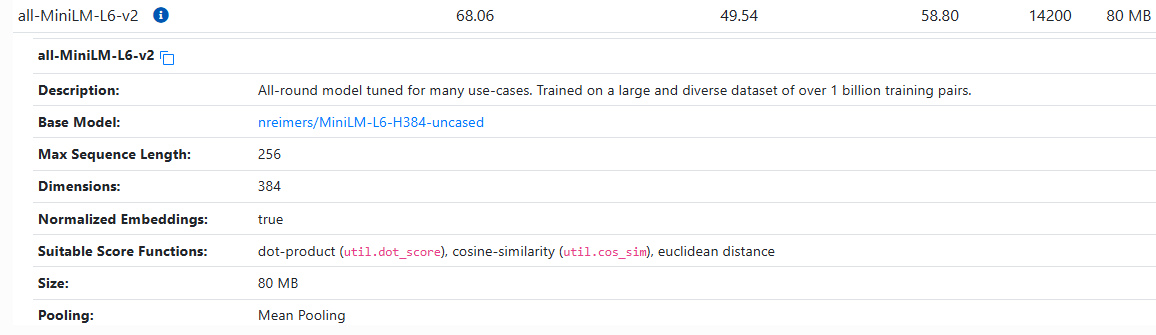

In [ ]:
#Load the Sentence Transformer model
model_name = 'all-MiniLM-L6-v2'
print(f"loading Sentence Transformer model: {model_name}..")
model = SentenceTransformer(model_name)
print("model loaded")

loading Sentence Transformer model: all-MiniLM-L6-v2..


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model loaded


## 5. Generate Sentence Embeddings


Now we use the SBERT model to convert each sentence (from both the sources and submission) into a numerical vector (embedding).

These embeddings will capture the semantic meanings of each sentence

In [ ]:
print("Generating embeddigns for source sentences...")
source_embeddings = model.encode(all_source_sentences_text, convert_to_tensor=True, show_progress_bar=True)

print("\nGenerating embeddings for submission sentences...")
submission_embeddings = model.encode(submission_sentences, convert_to_tensor=True, show_progress_bar=True)

print("\nEmbeddings Generated")
print(f"Source Embeddings shape: {source_embeddings.shape}")
print(f"Submission Embeddings shape: {submission_embeddings.shape}") # (number of sentences, embedding dimension)

Generating embeddigns for source sentences...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


Generating embeddings for submission sentences...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Embeddings Generated
Source Embeddings shape: torch.Size([42, 384])
Submission Embeddings shape: torch.Size([28, 384])


## 6. Similarity Metrics (Theory)

### 6.1 Cosine Similarity (Semantic Similarity)

**What it measures?**
- The cosine of the angle between two vectors. In the context of SBERT embeddings, it measures how "semantically" simialr two sentences are

**Range (0-1):**
- `0`: Setences have very differnt meanings (vectors are orthogonal/perpandicular)
- `1`: Setences have very similar meanings (vectors point in the same direction/parellel)

**Justification:**
- To find pairs of submission/source sentences that discuss the same *concept*, even if worded differntly. We look for values above a certain threshold (`COSINE_THRESHOLD`)

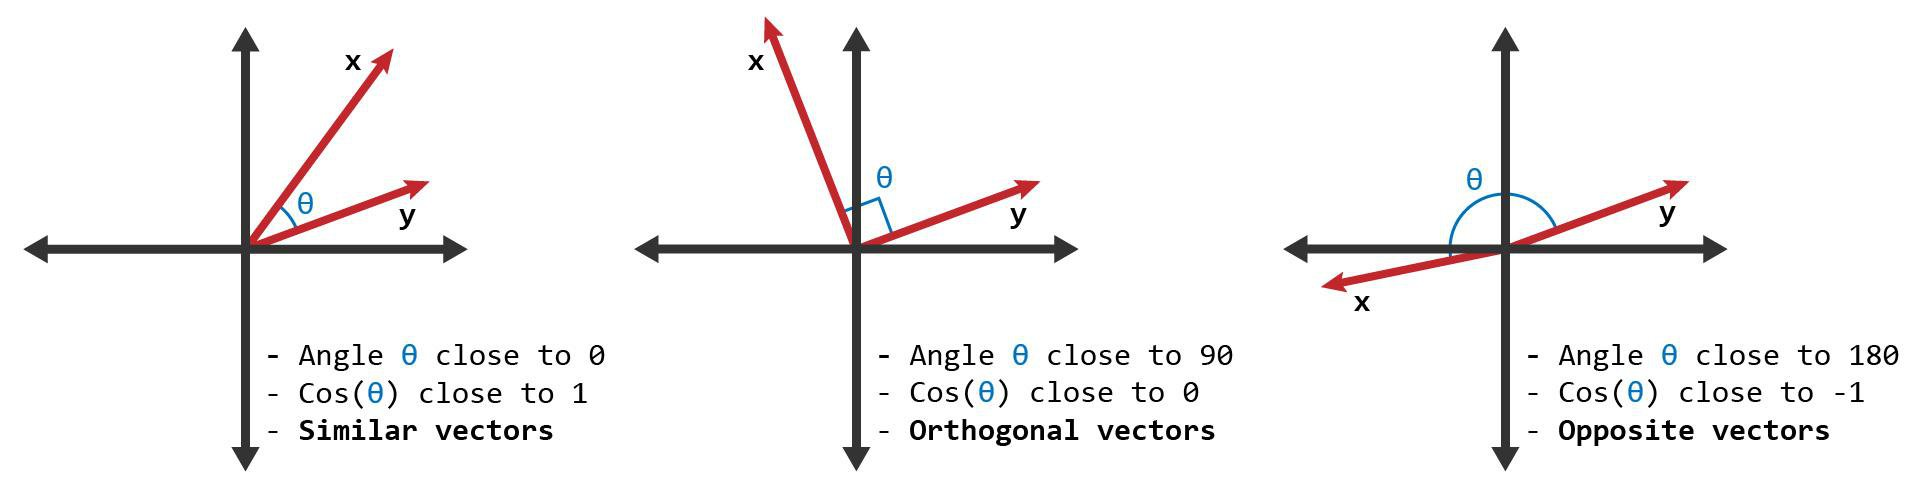

### 6.2 Jaccard Similarity (Lexical Overlap)

**What it measures?**
- The overlap between two sets of words
- calcuated as `(number of common words) / (Total number of unique words in both sentences)`
- General terms `(A Intersect B) / (A Union B)`

**Range (0-1):**
- `0`: The sentences have no words in common
- `1`: The sentences use the exactr same set of words

**Justification:**
- To measures how much the word *wording* overlaps. Paraphrasing aims to use differnt words while keeping the meaning. Therefore using Jaccard similaroty below a certain threshold (`JACCARD_THRESHOLD`) to filter out direct quotes or pairs with high word overlap.

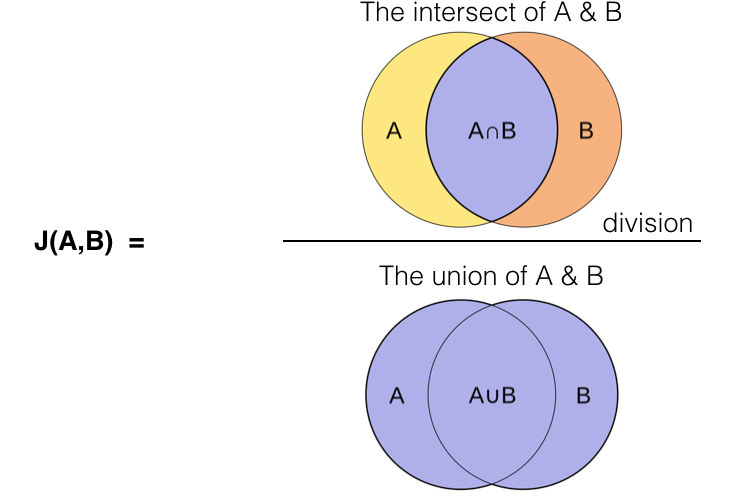

### 6.3 Combining Metrics for Paraphrasing Detection

Our strategy relies on combining these two metrics:

- **High Cosine Similarity** (`> COSINE_THRESHOLD`) suggest the sentences have similar meaning
- **Low Jaccard Similarity** (`< JACCARD_THRESHOLD`) suggests the sentences use signficantly different wording.

submission/source sentence pairs that match *both* criteria are flagged as potential candidates for **paraphrased plagiarism**

## 7. Calculating the Similarities and Filter Candidates



1.   Calculate all pairwise Cosine Similarities between submission and sentences.
2.  Define a function to calculate the Jaccard Similairty
3. Set appropriate thresholds for Cosine and Jaccard Simialrity (**Likely need to tune these based on results**)
4. Iterate throough submission sentences and find source sentences with high cosine similairty, and then check if their Jaccard Similairty is low.
5. Store the flagged pairs



Jaccard Function

In [ ]:
def calculate_jaccard(text1, text2):
  """Calcs Jaccard Similairty between the word sets of two texts"""
  tokens1 = set(word_tokenize(text1.lower()))
  tokens2 = set(word_tokenize(text2.lower()))

  intersection = tokens1.intersection(tokens2)
  union = tokens1.union(tokens2)

  if not union:
    return 0.0 #advoid divions by zero error

  return len(intersection) / len(union)

Thresholds (to be tuned based upon intial performance)

In [ ]:
COSINE_THRESHOLD = 0.70 # Minimum semantic similarity to be considered "related"
JACCARD_THRESHOLD = 0.35 # Maximun lexical overlap allowed for a pair to be considered "paraphrased"

calculation

In [ ]:
print(f"Using Cosine Threshold: > {COSINE_THRESHOLD}")
print(f"Using Jaccard Threshold < {JACCARD_THRESHOLD}")
print("\nCalculating similarities and checking for paraphrasing candidates...")

flagged_paraphrases = []

# Calculate all pairwise cosine similarities
cosine_scores = util.pytorch_cos_sim(submission_embeddings, source_embeddings).cpu().numpy() #moves result to cpu and then a numPy array
print(f"Cosine similarity matrix shape: {cosine_scores.shape}") # dimensions (number of submission sentences, number of source sentences)

# Iterate through the step submission sentences
for submission_idx, submission_sentence in enumerate(submission_sentences):
  high_consnde_indices = np.where(cosine_scores[submission_idx] >= COSINE_THRESHOLD)[0] #np.where returns a tuple of arrays but we only need first element [0]

  #if any met criteria
  if len(high_consnde_indices) > 0:
    #for those candidates calculate the Jaccard similairty
    for source_idx in high_consnde_indices:
      source_sentence_info = source_sentences_info[source_idx]
      source_sentence = source_sentence_info["text"]

      jaccard_similarity = calculate_jaccard(submission_sentence, source_sentence)

      if jaccard_similarity < JACCARD_THRESHOLD:
        cosine_similarity = cosine_scores[submission_idx][source_idx] #get the specific score
        # Flag this pair as potential paraphrase
        flagged_paraphrases.append(
            {
                "submission_sentence": submission_sentence,
                "submission_index" : submission_idx + 1,
                "source_sentence" : source_sentence,
                "source_index" : source_idx, #enhance readability to align index and sentence number in results
                "source_origin" : source_sentence_info["source"],
                "source_index_in_origin" : source_sentence_info["source_index"] + 1, #enhance readability to align index and sentence number in results
                "cosine_similarity" : float(f"{cosine_similarity:.4f}"), #format for readability
                "jaccard_similarity" : float(f"{jaccard_similarity:4f}")
            }
        )

print(f"\nFinished calculation. Found {len(flagged_paraphrases)} potential paraphrasing candidates")

Using Cosine Threshold: > 0.7
Using Jaccard Threshold < 0.35

Calculating similarities and checking for paraphrasing candidates...
Cosine similarity matrix shape: (28, 42)

--- Investigating Specific False Negative (SUB-14 vs WWII-S15) ---
Submission Sentence (Target: SUB-14, Index 13): 'The Second World War fundamentally altered the world's political arrangements, economic frameworks, and societal makeup, laying the groundwork for how nations would interact throughout the remainder of the 20th century and even into the 21st.'
Source Sentence (Target: WWII-S15, Global Index 37): 'World War II transformed the political, economic, and social structures of the world, and established the foundation of international relations for the rest of the 20th century and into the 21st century.'

Calculated Scores for this pair:
  Cosine Similarity: 0.8044
  Jaccard Similarity: 0.3500

Thresholds Used:
  Cosine Threshold: > 0.7
  Jaccard Threshold: < 0.35
  Reason for miss: Jaccard similarity (0.3500

## 8 Results (Baseline Model)

In [ ]:
#sort by highest first
flagged_paraphrases.sort(key=lambda x: x['cosine_similarity'], reverse=True)

if flagged_paraphrases:
    print("\n--- Potential Paraphrased Pairs (Sorted by Cosine Similarity) ---")
    for i, pair in enumerate(flagged_paraphrases):
        print(f"\nCandidate {i+1}:")
        print(f"  Submission Sentence (Index {pair['submission_index']}):")
        print(f"    '{pair['submission_sentence']}'")
        print(f"  Potential Source Sentence (From: {pair['source_origin']}, Original Index: {pair['source_index_in_origin']}):")
        print(f"    '{pair['source_sentence']}'")
        print(f"  Scores: Cosine Similarity = {pair['cosine_similarity']} (> {COSINE_THRESHOLD}), Jaccard Similarity = {pair['jaccard_similarity']} (< {JACCARD_THRESHOLD})")
        print("-" * 20) # Separator
else:
    print("\nNo potential paraphrasing candidates found with the current thresholds.")
    print("Consider adjusting the COSINE_THRESHOLD (lower?) or JACCARD_THRESHOLD (higher?) if you expected results.")


--- Potential Paraphrased Pairs (Sorted by Cosine Similarity) ---

Candidate 1:
  Submission Sentence (Index 25):
    'In the unsupervised learning approach, algorithms are not provided with labeled examples; instead, they must independently identify inherent structures or patterns within the input data they receive.'
  Potential Source Sentence (From: Machine Learning, Original Index: 4):
    'Unsupervised learning: No labels are given to the learning algorithm, leaving it on its own to find structure in its input.'
  Scores: Cosine Similarity = 0.819 (> 0.7), Jaccard Similarity = 0.195122 (< 0.35)
--------------------

Candidate 2:
  Submission Sentence (Index 23):
    'Machine learning, a key area within artificial intelligence, involves creating statistical algorithms capable of discerning patterns from data and applying that knowledge to new, unseen information, thereby accomplishing tasks without needing step-by-step programming.'
  Potential Source Sentence (From: Machine Learn

## 9. Evaluation against Ground Truth (baseline model)

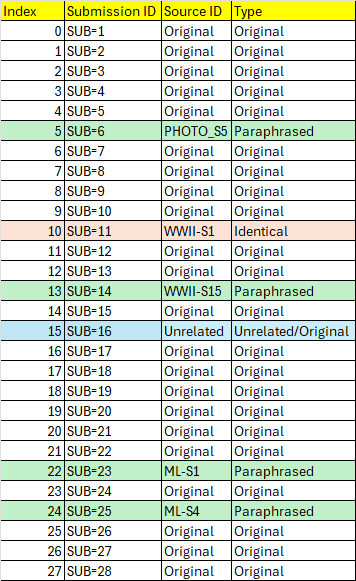

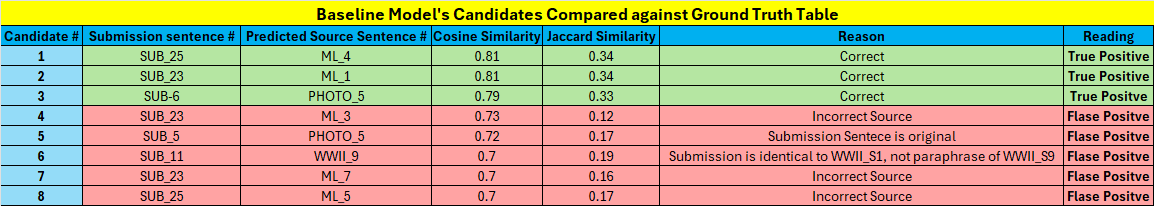

---

True Positive (TP): 3

False Positive (FP): 5

Flase Negative (FN): 1 (model did not indentify SUB_14 as a paraphrased candidate)

Number of actual "Paraphrased" instances in Ground Truth = TP + FN = 3 + 1 = 4

Precision: TP/(TP+FP) = 3 / 8 = 0.375

Recall: TP / (TP + FN) = 3 / 4 = 0.75

F1-Score: 2 x (Precision x Recall) / (Precision + Recall) = 2 x (0.375 x 0.75) / (0.375 + 0.75) = 0.5

---


The developed system, using a cosine similarity threshold of >0.7 and a Jaccard similarity threshold of <0.35 with the `all-MiniLM-L6-v2` model, was evaluated on the synthetic dataset.

- Overall Performance: The system achieved a Precision of 0.375, a Recall of 0.75, and an F1-Score of 0.50.
- True Positives: It successfully identified 3 out of the 4 intentionally paraphrased instances in the submission document.
- False Negatives: One instance of paraphrasing (SUB-14 from WWII-S15) was not detected.
- False Positives: The system generated 5 false positives. These included:
  - Matching original submission sentences to semantically related source sentences.
  - Matching paraphrased submission sentences to incorrect (but topically related) source sentences within the same source document.
  - Matching an identical submission sentence (SUB-11) to a different, though semantically similar, source sentence due to low lexical overlap with that specific incorrect source.
- Identical Content Handling: The system correctly excluded the truly identical sentence pair (SUB-11 from WWII-S1) from being flagged as a paraphrase, due to its high Jaccard similarity exceeding the filter's upper bound. This demonstrates the effectiveness of the lexical filter for distinguishing direct quotes.

Conclusively, the baseline system shows good recall in detecting most paraphrased content and correctly handles identical sentences but suffers from lower precision due to a notable number of false positives. The primary challenge appears to be differentiating between true paraphrases and other semantically similar but non-plagiarized (or differently sourced) sentence pairs."



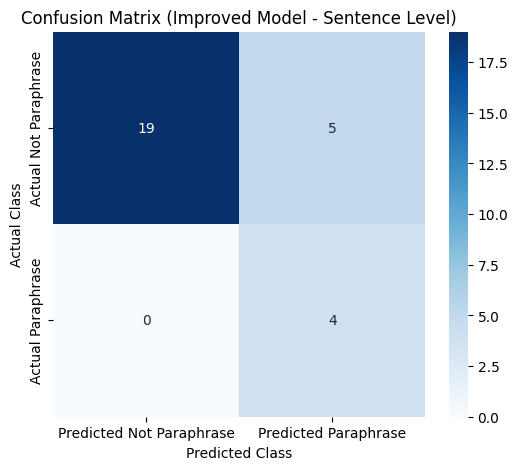

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Baseline Model Data
tp = 4
fp = 5
fn = 0
# Based on 28 submission sentences, 4 of which are actual paraphrases
total_actual_non_paraphrase_sentences = 28 - 4
tn = total_actual_non_paraphrase_sentences - fp # 24 - 5 = 19

# Create the confusion matrix array
conf_matrix = np.array([[tn, fp],
                        [fn, tp]])

# Plotting (optional, for visual appeal if you have time to generate an image)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Not Paraphrase', 'Predicted Paraphrase'],
            yticklabels=['Actual Not Paraphrase', 'Actual Paraphrase'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix (Improved Model - Sentence Level)')
plt.show()

# For your improved model:
# True Positives (TP): 4
# False Positives (FP): 5 (assuming this didn't change with Jaccard adjustment - check your flagged pairs!)
# False Negatives (FN): 0
# TN_improved = total_actual_non_paraphrase_sentences - FP = 24 - 5 = 19 (if FP remains 5)

# conf_matrix_improved = np.array([[tn_improved, fp],
#                                  [fn, tp_improved]])
# ... plot improved matrix ...

### Investigating the False Negative

In [ ]:
print("\n--- Investigating Specific False Negative (SUB-14 vs WWII-S15) ---")

# --- Manually identify the 0-based indices ---


sub_fn_text_target = "SUB-14" # As per your ground truth image's "Submission ID"
source_fn_text_target_id = "WWII-S15"
source_fn_origin_target = "World War 2" # Match the 'source' key in source_sentences_detailed

idx_sub_fn_0based = 13 # Example: Corresponds to SUB-14 if image "Index" is 0-based

idx_src_fn_0based = -1
target_source_original_0based_index = 14 # WWII-S15 means 15th sentence, so 0-based index 14 within that source

for i, detail in enumerate(source_sentences_info):
    if detail["source"] == source_fn_origin_target and detail["source_index"] == target_source_original_0based_index:
        idx_src_fn_0based = i # This is the global 0-based index in all_source_sentences_text
        break

if idx_sub_fn_0based < len(submission_sentences) and idx_src_fn_0based != -1:
    sub_sentence_fn_text = submission_sentences[idx_sub_fn_0based]
    sub_sentence_fn_emb = submission_embeddings[idx_sub_fn_0based]

    src_sentence_fn_text = source_sentences_info[idx_src_fn_0based]["text"]
    src_sentence_fn_emb = source_embeddings[idx_src_fn_0based]

    print(f"Submission Sentence (Target: {sub_fn_text_target}, Index {idx_sub_fn_0based}): '{sub_sentence_fn_text}'")
    print(f"Source Sentence (Target: {source_fn_text_target_id}, Global Index {idx_src_fn_0based}): '{src_sentence_fn_text}'")

    # Calculate Cosine Similarity for this specific pair
    cos_sim_fn = util.pytorch_cos_sim(sub_sentence_fn_emb.unsqueeze(0), src_sentence_fn_emb.unsqueeze(0)).item()

    # Calculate Jaccard Similarity
    jacc_sim_fn = calculate_jaccard(sub_sentence_fn_text, src_sentence_fn_text)

    print(f"\nCalculated Scores for this pair:")
    print(f"  Cosine Similarity: {cos_sim_fn:.4f}")
    print(f"  Jaccard Similarity: {jacc_sim_fn:.4f}")

    print(f"\nThresholds Used:")
    print(f"  Cosine Threshold: > {COSINE_THRESHOLD}")
    print(f"  Jaccard Threshold: < {JACCARD_THRESHOLD}")

    # Analyse why it was missed
    missed = False
    if cos_sim_fn <= COSINE_THRESHOLD:
        print(f"  Reason for miss: Cosine similarity ({cos_sim_fn:.4f}) is NOT > {COSINE_THRESHOLD}.")
        missed = True
    if jacc_sim_fn >= JACCARD_THRESHOLD: # Note: condition is >= because we want it to be <
        print(f"  Reason for miss: Jaccard similarity ({jacc_sim_fn:.4f}) is NOT < {JACCARD_THRESHOLD} (it's too high or equal).")
        missed = True

    if not missed and cos_sim_fn > COSINE_THRESHOLD and jacc_sim_fn < JACCARD_THRESHOLD:
        print("  This pair SHOULD have been flagged with current thresholds. Double-check logic or if it was overwritten/missed in the main loop.")
print("--- End of False Negative Investigation ---")


--- Investigating Specific False Negative (SUB-14 vs WWII-S15) ---
Submission Sentence (Target: SUB-14, Index 13): 'The Second World War fundamentally altered the world's political arrangements, economic frameworks, and societal makeup, laying the groundwork for how nations would interact throughout the remainder of the 20th century and even into the 21st.'
Source Sentence (Target: WWII-S15, Global Index 37): 'World War II transformed the political, economic, and social structures of the world, and established the foundation of international relations for the rest of the 20th century and into the 21st century.'

Calculated Scores for this pair:
  Cosine Similarity: 0.8044
  Jaccard Similarity: 0.3500

Thresholds Used:
  Cosine Threshold: > 0.7
  Jaccard Threshold: < 0.35
  Reason for miss: Jaccard similarity (0.3500) is NOT < 0.35 (it's too high or equal).
--- End of False Negative Investigation ---


This specific investigation of this pair revealed a high Cosine Similarity of 0.8044, well above the 0.7 threshold, indicating the model correctly identified strong semantic relatedness. However, the Jaccard Similarity was calculated to be 0.3500. As our current Jaccard threshold for flagging a paraphrase requires a score strictly less than 0.35, this pair was filtered out due to its Jaccard score being at the boundary. This suggests that the paraphrasing, while significant enough to change wording, retained a lexical overlap that was precisely at our filter's cutoff.

## 10. Data Driven Improvements (Improved Model)

The analysis of the false negative (SUB-14/WWII-S15) provides a clear avenue for potential improvement through threshold tuning. The Jaccard similarity of 0.3500 for this genuinely paraphrased pair indicates that our initial Jaccard threshold of < 0.35 might be slightly too restrictive.

Potential Improvement Strategy: Adjusting Jaccard Threshold

We could explore slightly relaxing the Jaccard threshold, for instance, by - changing the condition to Jaccard <= 0.35 or even Jaccard < 0.36 (or a slightly higher value like Jaccard < 0.40).

- Hypothesised Impact:
  - Pro: This change would likely allow the system to correctly identify the previously missed SUB-14/WWII-S15 pair, thereby improving Recall.
  - Con: Relaxing the Jaccard threshold (i.e., allowing slightly more lexical overlap to still be considered a paraphrase) might increase the risk of False Positives. Specifically, it could start flagging sentences that are very close to direct quotes, or sentences that are only minimally rephrased, as paraphrases. This would negatively impact Precision.

In [ ]:
COSINE_THRESHOLD = 0.70 # Minimum semantic similarity to be considered "related"
JACCARD_THRESHOLD = 0.36 # Maximun lexical overlap allowed for a pair to be considered "paraphrased"

In [ ]:
print(f"Using Cosine Threshold: > {COSINE_THRESHOLD}")
print(f"Using Jaccard Threshold < {JACCARD_THRESHOLD}")
print("\nCalculating similarities and checking for paraphrasing candidates...")

flagged_paraphrases = []

# Calculate all pairwise cosine similarities
cosine_scores = util.pytorch_cos_sim(submission_embeddings, source_embeddings).cpu().numpy() #moves result to cpu and then a numPy array
print(f"Cosine similarity matrix shape: {cosine_scores.shape}") # dimensions (number of submission sentences, number of source sentences)

# Iterate through the step submission sentences
for submission_idx, submission_sentence in enumerate(submission_sentences):
  high_consnde_indices = np.where(cosine_scores[submission_idx] >= COSINE_THRESHOLD)[0] #np.where returns a tuple of arrays but we only need first element [0]

  #if any met criteria
  if len(high_consnde_indices) > 0:
    #for those candidates calculate the Jaccard similairty
    for source_idx in high_consnde_indices:
      source_sentence_info = source_sentences_info[source_idx]
      source_sentence = source_sentence_info["text"]

      jaccard_similarity = calculate_jaccard(submission_sentence, source_sentence)

      if jaccard_similarity < JACCARD_THRESHOLD:
        cosine_similarity = cosine_scores[submission_idx][source_idx] #get the specific score
        # Flag this pair as potential paraphrase
        flagged_paraphrases.append(
            {
                "submission_sentence": submission_sentence,
                "submission_index" : submission_idx + 1,
                "source_sentence" : source_sentence,
                "source_index" : source_idx, #enhance readability to align index and sentence number in results
                "source_origin" : source_sentence_info["source"],
                "source_index_in_origin" : source_sentence_info["source_index"] + 1, #enhance readability to align index and sentence number in results
                "cosine_similarity" : float(f"{cosine_similarity:.4f}"), #format for readability
                "jaccard_similarity" : float(f"{jaccard_similarity:4f}")
            }
        )

print(f"\nFinished calculation. Found {len(flagged_paraphrases)} potential paraphrasing candidates")

#sort by highest first
flagged_paraphrases.sort(key=lambda x: x['cosine_similarity'], reverse=True)

if flagged_paraphrases:
    print("\n--- Potential Paraphrased Pairs (Sorted by Cosine Similarity) ---")
    for i, pair in enumerate(flagged_paraphrases):
        print(f"\nCandidate {i+1}:")
        print(f"  Submission Sentence (Index {pair['submission_index']}):")
        print(f"    '{pair['submission_sentence']}'")
        print(f"  Potential Source Sentence (From: {pair['source_origin']}, Original Index: {pair['source_index_in_origin']}):")
        print(f"    '{pair['source_sentence']}'")
        print(f"  Scores: Cosine Similarity = {pair['cosine_similarity']} (> {COSINE_THRESHOLD}), Jaccard Similarity = {pair['jaccard_similarity']} (< {JACCARD_THRESHOLD})")
        print("-" * 20) # Separator
else:
    print("\nNo potential paraphrasing candidates found with the current thresholds.")
    print("Consider adjusting the COSINE_THRESHOLD (lower?) or JACCARD_THRESHOLD (higher?) if you expected results.")

Using Cosine Threshold: > 0.7
Using Jaccard Threshold < 0.36

Calculating similarities and checking for paraphrasing candidates...
Cosine similarity matrix shape: (28, 42)

Finished calculation. Found 9 potential paraphrasing candidates

--- Potential Paraphrased Pairs (Sorted by Cosine Similarity) ---

Candidate 1:
  Submission Sentence (Index 25):
    'In the unsupervised learning approach, algorithms are not provided with labeled examples; instead, they must independently identify inherent structures or patterns within the input data they receive.'
  Potential Source Sentence (From: Machine Learning, Original Index: 4):
    'Unsupervised learning: No labels are given to the learning algorithm, leaving it on its own to find structure in its input.'
  Scores: Cosine Similarity = 0.819 (> 0.7), Jaccard Similarity = 0.195122 (< 0.36)
--------------------

Candidate 2:
  Submission Sentence (Index 23):
    'Machine learning, a key area within artificial intelligence, involves creating st

### Improved Model Results

Key Change in Output:
- now have 9 candidates instead of 8.
- The new candidate(Candidate 3) is our previously missed False Negative!
- we now have another true positive candidate and zero false Negative Candidates

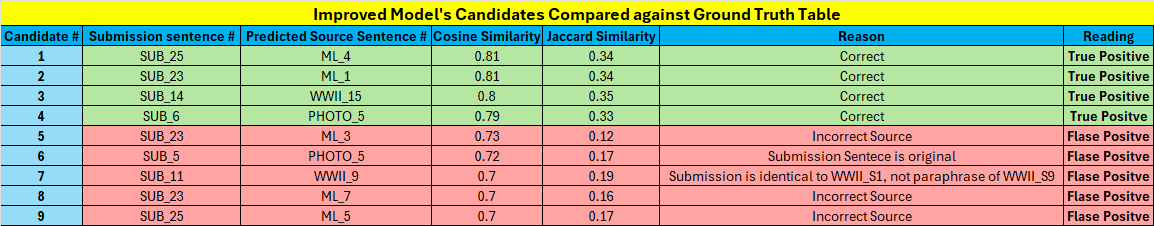

---
New Metrics (Jaccard < 0.36, Cosine > 0.7):

True Positives (TP): 4

False Positives (FP): 5

False Negatives (FN): 0

Precision: TP / (TP + FP) = 4 / (4 + 5) = 4 / 9 = 0.444

Recall: TP / (TP + FN) = 4 / (4 + 0) = 4 / 4 = 1.0

F1-Score: 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.444 * 1.0) / (0.444 + 1.0) = 2 * 0.444 / 1.444 = 0.888 / 1.444 = 0.615

---

- achieved perfect Recall (found all true paraphrases).
- Precision also improved slightly (because you gained a TP without gaining an FP from this specific change related to the Jaccard boundary).
- F1-Score shows a significant overall improvement.

## 11. Findings

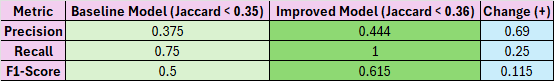

This project successfully developed and evaluated a system for identifying paraphrased plagiarism. By leveraging Sentence-BERT embeddings for semantic understanding and coupling Cosine Similarity with a Jaccard Similarity filter, the system aims to distinguish between genuine paraphrasing and direct quotations or unrelated text.

Our experiments on a custom synthetic dataset showed promising results. An initial baseline model (Cosine >0.7, Jaccard <0.35) achieved an F1-Score of 0.50. A targeted adjustment to the Jaccard threshold (to <0.36), based on a specific false negative case, significantly improved performance, yielding a Recall of 1.0 and an F1-Score of 0.615. This demonstrates the system's capability to detect all intended paraphrases in our test set and correctly ignore identical sentences.

Despite these improvements, the system still generated several false positives, primarily by matching submission sentences to semantically similar but incorrect source sentences; interestingly, all these false positives fell within a narrow Cosine Similarity range (0.70-0.73). While slightly increasing the Cosine threshold to >0.73 could eliminate these specific false positives in our dataset, such a precise cutoff is subjective and risks missing more nuanced paraphrases in real-world applications. Future work will focus on refining thresholds with more diverse data, exploring different embedding models, and implementing advanced post-processing logic to reduce false positives and enhance overall precision. Nevertheless, this project establishes a viable NLP-based approach for tackling the challenge of paraphrased plagiarism detection.